In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
xhlulu_140k_real_and_fake_faces_path = kagglehub.dataset_download('xhlulu/140k-real-and-fake-faces')

print('Data source import complete.')


In [ ]:
import cv2
import numpy as np
from PIL import Image
import io

def apply_ela(image_array, quality=90):
    """
    Applique l'Error Level Analysis (ELA) sur une image en format numpy array.

    :param image_array: Image sous forme de tableau numpy.
    :param quality: Qualité de compression JPEG.
    :return: Image ELA normalisée.
    """
    # Convertir en image PIL
    pil_image = Image.fromarray((image_array * 255).astype(np.uint8))

    # Sauvegarde dans un buffer en mémoire
    buffer = io.BytesIO()
    pil_image.save(buffer, "JPEG", quality=quality)
    buffer.seek(0)
    compressed_image = Image.open(buffer)

    # Convertir en numpy array
    original_array = np.array(pil_image)
    compressed_array = np.array(compressed_image)

    # Vérifier si les tailles correspondent
    if original_array.shape != compressed_array.shape:
        compressed_array = cv2.resize(compressed_array, (original_array.shape[1], original_array.shape[0]))

    # Calcul de l'ELA
    ela_image = np.abs(original_array.astype(np.float32) - compressed_array.astype(np.float32))

    # Normalisation pour éviter les valeurs hors plage
    max_val = np.max(ela_image)
    if max_val > 0:
        ela_image = (ela_image / max_val) * 255
    ela_image = np.clip(ela_image, 0, 255).astype(np.uint8)

    return ela_image

def ela_preprocessing(image):
    """
    Applique l'ELA et redimensionne l'image.

    :param image: Image au format numpy array.
    :return: Image ELA redimensionnée et normalisée.
    """
    # Appliquer ELA
    ela_image = apply_ela(image)

    # Vérifier si l'image est en niveaux de gris et la convertir en RGB
    if len(ela_image.shape) == 2:
        ela_image = cv2.cvtColor(ela_image, cv2.COLOR_GRAY2RGB)

    # Redimensionner
    ela_image = cv2.resize(ela_image, (128, 128))

    # Normaliser entre 0 et 1
    ela_image = ela_image / 255.0

    return ela_image


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Chemins des dossiers
train_dir = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train'
validation_dir = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid'
test_dir = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test'

batch_size = 32
img_height, img_width = 128, 128

# Définition d'un générateur avec ELA
train_datagen = ImageDataGenerator(preprocessing_function=lambda img: ela_preprocessing(img))

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)


Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


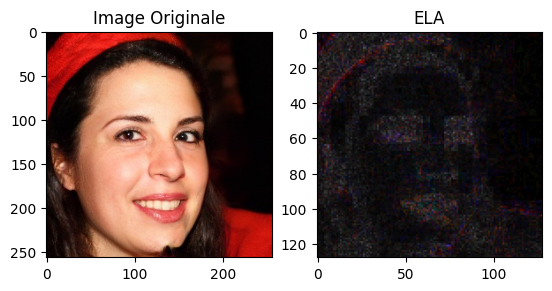

In [ ]:
import matplotlib.pyplot as plt

img_path = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train/fake/001DDU0NI4.jpg"
img = Image.open(img_path)
img_array = np.array(img) / 255.0  # Normalisation

ela_img = ela_preprocessing(img_array)

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Image Originale")

plt.subplot(1, 2, 2)
plt.imshow(ela_img)
plt.title("ELA")

plt.show()


[0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0.
 0. 0. 0. 1. 1. 1. 0. 1.]


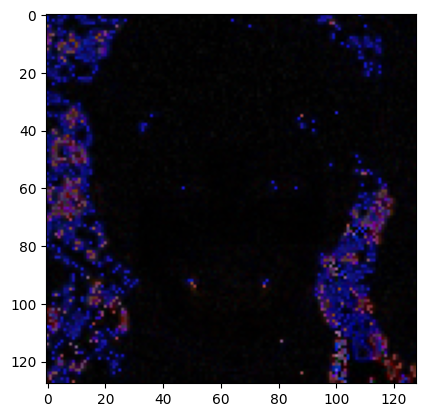

In [ ]:
x_batch, y_batch = next(train_generator)
print(y_batch)  # Vérifier si c'est bien 0 et 1
plt.imshow(x_batch[0])  # Visualiser une image du batch
plt.show()


In [ ]:
from collections import Counter

class_counts = Counter(train_generator.classes)
print(class_counts)  # Vérifie si une classe est sur-représentée


Counter({0: 50000, 1: 50000})


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

def build_custom_cnn():
    model = models.Sequential()

    model.add(layers.InputLayer(input_shape=(128, 128, 3)))

    model.add(layers.Conv2D(32, (5, 5), activation='relu', kernel_initializer="he_normal"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer="he_normal"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer="he_normal"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Flatten())

    model.add(layers.Dense(128, activation='relu', kernel_initializer="he_normal"))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(1, activation='sigmoid'))

    return model

model = build_custom_cnn()
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)                   │ (None, 124, 124, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 124, 124, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 60, 60, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 60, 60, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,307,713 (12.62 MB)

 Trainable params: 3,307,009 (12.62 MB)

 Non-trainable params: 704 (2.75 KB)

In [ ]:

import time
from tensorflow.keras.callbacks import Callback


class TimingCallback(Callback):
    def on_train_begin(self, logs=None):
        self.train_start_time = time.time()

    def on_train_end(self, logs=None):
        self.train_end_time = time.time()
        training_time = self.train_end_time - self.train_start_time
        print(f"Training completed in {training_time:.2f} seconds.")

# Créer une instance de votre callback personnalisé
timing_callback = TimingCallback()

# Early stopping to prevent overfitting
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Compiler le modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Train the model using data augmentation
history = model.fit(train_generator,
                    epochs=20,
                    validation_data=validation_generator,
                    callbacks=[timing_callback])

Epoch 1/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 760s 240ms/step - accuracy: 0.6221 - loss: 0.6906 - val_accuracy: 0.5071 - val_loss: 1.4807
Epoch 2/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 320s 102ms/step - accuracy: 0.7582 - loss: 0.4926 - val_accuracy: 0.5080 - val_loss: 3.3453
Epoch 3/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 317s 101ms/step - accuracy: 0.8072 - loss: 0.4184 - val_accuracy: 0.5017 - val_loss: 2.9050
Epoch 4/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 311s 99ms/step - accuracy: 0.8256 - loss: 0.3853 - val_accuracy: 0.5005 - val_loss: 4.8906
Epoch 5/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 303s 97ms/step - accuracy: 0.8469 - loss: 0.3505 - val_accuracy: 0.5008 - val_loss: 7.5271
Epoch 6/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 301s 96ms/step - accuracy: 0.8567 - loss: 0.3308 - val_accuracy: 0.5037 - val_loss: 5.4180
Epoch 7/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 361s 115ms/step - accuracy: 0.8681 - loss: 0.3103 - val_accuracy: 0.5002 - val_loss: 8.7152
Epoch 8/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 312s 100ms/step - accur

Création du modèle...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,289,474 (16.36 MB)

 Trainable params: 4,289,474 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

Début de l'entraînement...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1107s 352ms/step - accuracy: 0.5546 - loss: 1.4103 - val_accuracy: 0.7078 - val_loss: 0.5615
Epoch 2/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 498s 159ms/step - accuracy: 0.7387 - loss: 0.5195 - val_accuracy: 0.7713 - val_loss: 0.4716
Epoch 3/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 417s 133ms/step - accuracy: 0.8179 - loss: 0.3964 - val_accuracy: 0.8199 - val_loss: 0.4012
Epoch 4/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 411s 131ms/step - accuracy: 0.8601 - loss: 0.3198 - val_accuracy: 0.8583 - val_loss: 0.3321
Epoch 5/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 411s 131ms/step - accuracy: 0.8903 - loss: 0.2627 - val_accuracy: 0.8684 - val_loss: 0.3107
Epoch 6/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 410s 131ms/step - accuracy: 0.9091 - loss: 0.2226 - val_accuracy: 0.8704 - val_loss: 0.3176
Epoch 7/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 409s 131ms/step - accuracy: 0.9203 - loss: 0.1966 - val_accuracy: 0.8687 - val_loss: 0.3209
Epoch 8/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 411s 131ms/step - accuracy: 0.

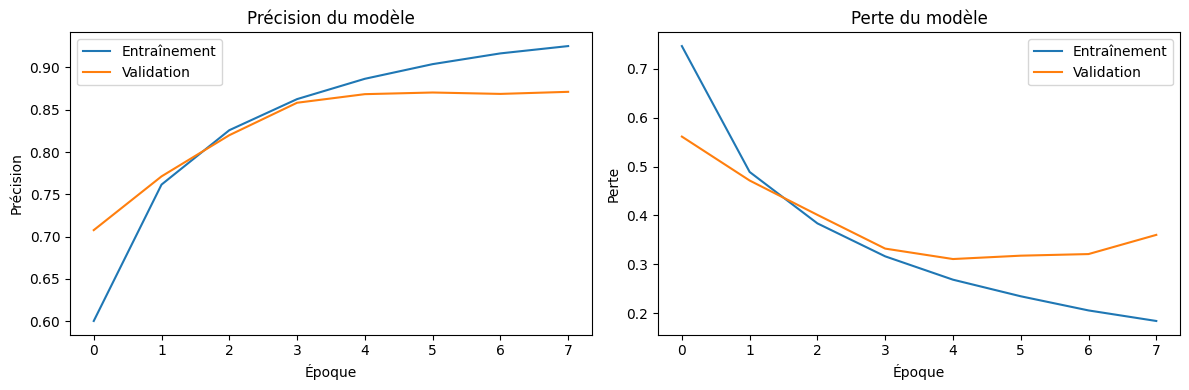


Modèle sauvegardé sous 'ela_face_detection_model.keras'


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from PIL import Image
import io
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Définition des chemins
train_dir = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train'
validation_dir = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid'
test_dir = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test'

def create_ela_cnn_model(input_shape=(128, 128, 3)):
    """
    Crée le modèle CNN pour la détection de faux visages
    """
    model = models.Sequential([
        layers.Conv2D(32, (5, 5), activation='relu', padding='same',
                     input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(2, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def process_ela_image(image_path, quality=90):
    """
    Génère une image ELA
    """
    try:
        image = Image.open(image_path).convert('RGB')
        image = image.resize((128, 128))

        buffer = io.BytesIO()
        image.save(buffer, format='JPEG', quality=quality)
        buffer.seek(0)
        compressed_image = Image.open(buffer)

        ela_image = np.array(image) - np.array(compressed_image)
        ela_image = ela_image / float(255)
        ela_image = np.clip(ela_image * 40, 0, 255).astype(np.uint8)

        return ela_image

    except Exception as e:
        print(f"Erreur lors du traitement de {image_path}: {e}")
        return None

class ELADataGenerator(tf.keras.utils.Sequence):
    """
    Générateur de données compatible avec Keras pour les images ELA
    """
    def __init__(self, directory, batch_size=32, target_size=(128, 128)):
        self.directory = directory
        self.batch_size = batch_size
        self.target_size = target_size
        self.classes = ['real', 'fake']
        self.class_indices = {cls: idx for idx, cls in enumerate(self.classes)}

        # Récupérer les chemins d'images et labels
        self.image_paths = []
        self.labels = []
        for class_name in self.classes:
            class_path = os.path.join(directory, class_name)
            if os.path.exists(class_path):
                for img_name in os.listdir(class_path):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.image_paths.append(os.path.join(class_path, img_name))
                        self.labels.append(self.class_indices[class_name])

        self.n = len(self.image_paths)
        self.indexes = np.arange(self.n)
        np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(self.n / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_x = []
        batch_y = []

        for idx in batch_indexes:
            img_path = self.image_paths[idx]
            ela_img = process_ela_image(img_path)

            if ela_img is not None:
                batch_x.append(ela_img)
                # One-hot encoding
                label = np.zeros(2)
                label[self.labels[idx]] = 1
                batch_y.append(label)

        return np.array(batch_x), np.array(batch_y)

    def on_epoch_end(self):
        np.random.shuffle(self.indexes)

def plot_training_history(history):
    """
    Affiche les courbes d'apprentissage
    """
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Entraînement')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Précision du modèle')
    plt.xlabel('Époque')
    plt.ylabel('Précision')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Entraînement')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Perte du modèle')
    plt.xlabel('Époque')
    plt.ylabel('Perte')
    plt.legend()

    plt.tight_layout()
    plt.show()

def main():
    # Paramètres
    BATCH_SIZE = 32
    EPOCHS = 20

    # Création des générateurs
    train_generator = ELADataGenerator(train_dir, batch_size=BATCH_SIZE)
    validation_generator = ELADataGenerator(validation_dir, batch_size=BATCH_SIZE)
    test_generator = ELADataGenerator(test_dir, batch_size=BATCH_SIZE)

    # Création du modèle
    print("Création du modèle...")
    model = create_ela_cnn_model()
    model.summary()

    # Callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )

    # Entraînement
    print("Début de l'entraînement...")
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=EPOCHS,
        callbacks=[early_stopping]
    )

    # Évaluation
    print("\nÉvaluation du modèle...")
    test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
    print(f"Précision sur l'ensemble de test: {test_accuracy:.4f}")

    # Visualisation
    plot_training_history(history)

    # Sauvegarde du modèle
    model.save('ela_face_detection_model.keras')
    print("\nModèle sauvegardé sous 'ela_face_detection_model.keras'")

if __name__ == "__main__":
    main()

In [ ]:
val_test_datagen = ImageDataGenerator(rescale=1./255)
test_dir = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test'
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Ensure test data is not shuffled
)

Found 20000 images belonging to 2 classes.


In [ ]:
def process_ela_image(image_path, quality=90):
    """
    Génère une image ELA
    """
    try:
        image = Image.open(image_path).convert('RGB')
        image = image.resize((128, 128))

        buffer = io.BytesIO()
        image.save(buffer, format='JPEG', quality=quality)
        buffer.seek(0)
        compressed_image = Image.open(buffer)

        ela_image = np.array(image) - np.array(compressed_image)
        ela_image = ela_image / float(255)
        ela_image = np.clip(ela_image * 40, 0, 255).astype(np.uint8)

        return ela_image

    except Exception as e:
        print(f"Erreur lors du traitement de {image_path}: {e}")
        return None


class ELADataGenerator(tf.keras.utils.Sequence):
    def __init__(self, directory, batch_size=32, target_size=(128, 128)):
        self.directory = directory
        self.batch_size = batch_size
        self.target_size = target_size
        self.classes = ['real', 'fake']
        self.class_indices = {cls: idx for idx, cls in enumerate(self.classes)}

        # Récupérer les chemins d'images et labels
        self.image_paths = []
        self.labels = []
        for class_name in self.classes:
            class_path = os.path.join(directory, class_name)
            if os.path.exists(class_path):
                for img_name in os.listdir(class_path):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.image_paths.append(os.path.join(class_path, img_name))
                        self.labels.append(self.class_indices[class_name])

        self.n = len(self.image_paths)
        self.indexes = np.arange(self.n)
        np.random.shuffle(self.indexes)

        self.classes = np.array(self.labels)  # Contient bien 20000 valeurs

    def __len__(self):
        return int(np.ceil(self.n / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_x = []
        batch_y = []

        for idx in batch_indexes:
            img_path = self.image_paths[idx]
            ela_img = process_ela_image(img_path)

            if ela_img is not None:
                batch_x.append(ela_img)
                # One-hot encoding
                label = np.zeros(2)
                label[self.labels[idx]] = 1
                batch_y.append(label)

        return np.array(batch_x), np.array(batch_y)

    def on_epoch_end(self):
        np.random.shuffle(self.indexes)



test_generator = ELADataGenerator(test_dir, batch_size=32)

625/625 ━━━━━━━━━━━━━━━━━━━━ 68s 108ms/step
Shape des prédictions : (20000, 2)
Taille de `true_classes` : 20000
Taille de `predicted_classes` : 20000


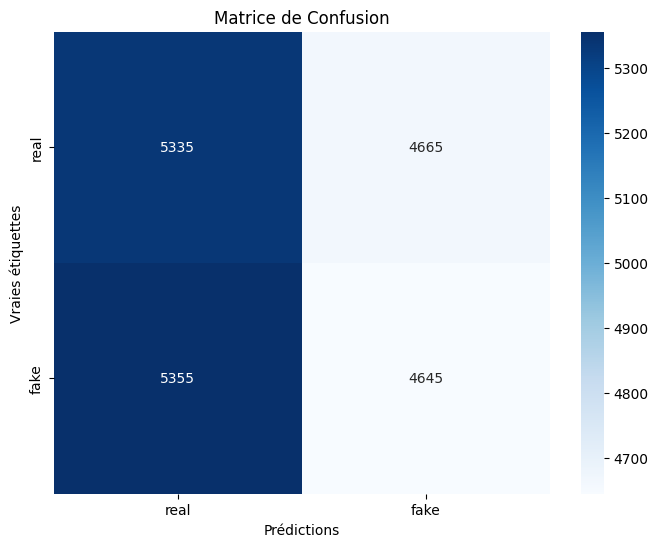

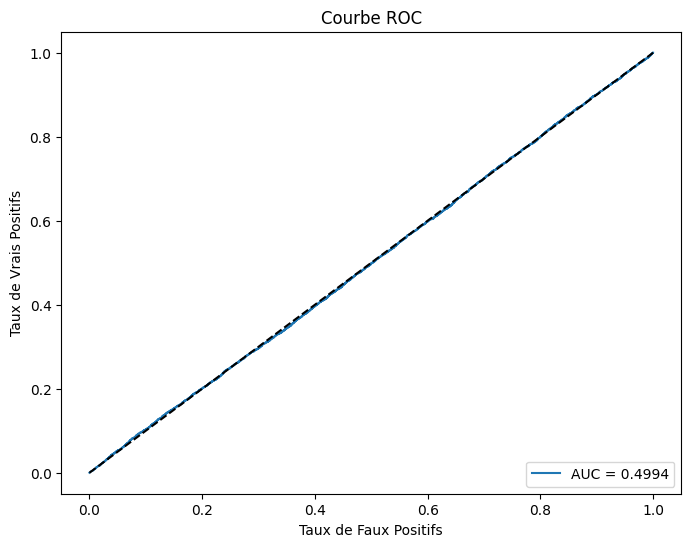

In [ ]:
# Importation des bibliothèques nécessaires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, matthews_corrcoef, cohen_kappa_score, log_loss
from tensorflow.keras.models import load_model

# Charger le modèle Keras
model = load_model("/kaggle/working/ela_face_detection_model.keras")

# Vérification des classes
class_labels = list(test_generator.class_indices.keys())

# Prédictions sur le jeu de test
#test_generator.reset()  # Réinitialisation du générateur de test
predictions = model.predict(test_generator, verbose=1)

# Vérification de la sortie du modèle
print(f"Shape des prédictions : {predictions.shape}")  # Doit être (N, 2) si Softmax

# Convertir les probabilités en labels (si sortie Softmax)
if predictions.shape[1] == 2:
    predicted_classes = np.argmax(predictions, axis=1)
else:
    predicted_classes = (predictions > 0.5).astype(int).reshape(-1)

#  Obtenir les vraies étiquettes
true_classes = test_generator.classes



#  Calcul de la matrice de confusion
cm = confusion_matrix(true_classes, predicted_classes)
tn, fp, fn, tp = cm.ravel()

# Calcul des métriques
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) != 0 else 0
recall = tp / (tp + fn) if (tp + fn) != 0 else 0
f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
auc = roc_auc_score(true_classes, predictions[:, 1] if predictions.shape[1] == 2 else predictions)
mcc = matthews_corrcoef(true_classes, predicted_classes)
kappa = cohen_kappa_score(true_classes, predicted_classes)
logloss = log_loss(true_classes, predictions)

# Création d'un dataframe pour stocker les métriques
metrics_dict = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Specificity': specificity,
    'AUC-ROC': auc,
    'MCC': mcc,
    'Cohen Kappa': kappa,
    'Log Loss': logloss
}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df.to_csv('model_metrics.csv', index=False)

# Affichage de la matrice de confusion
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Vraies étiquettes')
plt.xlabel('Prédictions')
plt.title('Matrice de Confusion')
plt.savefig('confusion_matrix.png')
plt.show()

# Tracé de la courbe ROC
fpr, tpr, thresholds = roc_curve(true_classes, predictions[:, 1] if predictions.shape[1] == 2 else predictions)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.savefig('roc_curve.png')
plt.show()

